<a href="https://colab.research.google.com/github/Guylord/Stock-Price-Prediction-using-LSTM/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing yfinance library to fetch financial data
import yfinance as yf

# Define the stock ticker symbol and download the historical stock data from Yahoo Finance
ticker = "AAPL"
data = yf.download(ticker, start="2016-01-01", end="2024-11-15")

# Resetting the index to have Date as a column instead of an index
data.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Previewing the data
data

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
0,2016-01-04 00:00:00+00:00,23.860582,26.337500,26.342501,25.500000,25.652500,270597600
1,2016-01-05 00:00:00+00:00,23.262650,25.677500,26.462500,25.602501,26.437500,223164000
2,2016-01-06 00:00:00+00:00,22.807405,25.174999,25.592501,24.967501,25.139999,273829600
3,2016-01-07 00:00:00+00:00,21.844831,24.112499,25.032499,24.107500,24.670000,324377600
4,2016-01-08 00:00:00+00:00,21.960342,24.240000,24.777500,24.190001,24.637501,283192000
...,...,...,...,...,...,...,...
2228,2024-11-08 00:00:00+00:00,226.960007,226.960007,228.660004,226.410004,227.169998,38328800
2229,2024-11-11 00:00:00+00:00,224.229996,224.229996,225.699997,221.500000,225.000000,42005600
2230,2024-11-12 00:00:00+00:00,224.229996,224.229996,225.589996,223.360001,224.550003,40398300


In [4]:
# Displaying the information of the DataFrame (structure, types, non-null counts, etc.)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2233 entries, 0 to 2232
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   (Date, )           2233 non-null   datetime64[ns, UTC]
 1   (Adj Close, AAPL)  2233 non-null   float64            
 2   (Close, AAPL)      2233 non-null   float64            
 3   (High, AAPL)       2233 non-null   float64            
 4   (Low, AAPL)        2233 non-null   float64            
 5   (Open, AAPL)       2233 non-null   float64            
 6   (Volume, AAPL)     2233 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 122.2 KB


In [5]:
# Checking the column names
data.columns

MultiIndex([(     'Date',     ''),
            ('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [6]:
# Renaming the columns to remove multi-level index (from 'Price' and 'Ticker') for easier access
data.columns = data.columns.map(lambda x: f"{x[0]}" if x[1] else x[0])
data.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [7]:
# Reordering the columns
column_order = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data = data.reindex(columns=column_order)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04 00:00:00+00:00,25.652500,26.342501,25.500000,26.337500,23.860582,270597600
1,2016-01-05 00:00:00+00:00,26.437500,26.462500,25.602501,25.677500,23.262650,223164000
2,2016-01-06 00:00:00+00:00,25.139999,25.592501,24.967501,25.174999,22.807405,273829600
3,2016-01-07 00:00:00+00:00,24.670000,25.032499,24.107500,24.112499,21.844831,324377600
4,2016-01-08 00:00:00+00:00,24.637501,24.777500,24.190001,24.240000,21.960342,283192000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2233 entries, 0 to 2232
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       2233 non-null   datetime64[ns, UTC]
 1   Open       2233 non-null   float64            
 2   High       2233 non-null   float64            
 3   Low        2233 non-null   float64            
 4   Close      2233 non-null   float64            
 5   Adj Close  2233 non-null   float64            
 6   Volume     2233 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 122.2 KB


In [9]:
# Extracting the 'Close' prices for use in the model
close_prices = data['Close'].values.reshape(-1, 1)

In [10]:
# Importing MinMaxScaler to normalize the data for the LSTM model
from sklearn.preprocessing import MinMaxScaler

# Scaling the close prices to the range 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [11]:
# Setting the sequence length (number of past days to look at for predicting the next day's price)
sequence_length = 60

# Preparing the input (X) and output (y) for model training
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

# Converting X and y into numpy arrays for use in training
X, y = np.array(X), np.array(y)

In [12]:
# Splitting the data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [29]:
# Importing necessary layers for the LSTM model from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Building the LSTM model
model = Sequential([
    LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(150, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1) # Output layer with one neuron (predicting the closing price)
])

# Compiling the model with Adam optimizer and Mean Squared Error loss function
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [30]:
# Training the model with the training data, validating on the test data, and using 50 epochs
model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0099 - val_loss: 6.0085e-04
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0695e-04 - val_loss: 6.4161e-04
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.6691e-04 - val_loss: 0.0049
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.2667e-04 - val_loss: 0.0014
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9792e-04 - val_loss: 4.9610e-04
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.1666e-04 - val_loss: 0.0012
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9422e-04 - val_loss: 9.3623e-04
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.2727e-04 - val_loss: 0.0014
Epoch 9/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.9699e-04 - val_loss: 5.1562e-04
Epoch 10/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2553e-04 - val_loss: 0.0016
Epoch 11/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8046e-04 - val_lo

In [31]:
# Making predictions using the trained LSTM model on the test data (X_test)
predictions = model.predict(X_test)

# Inverse transforming the predictions back to the original scale of stock prices using the scaler
# This converts the normalized predicted values back to their actual price values
predictions = scaler.inverse_transform(predictions)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


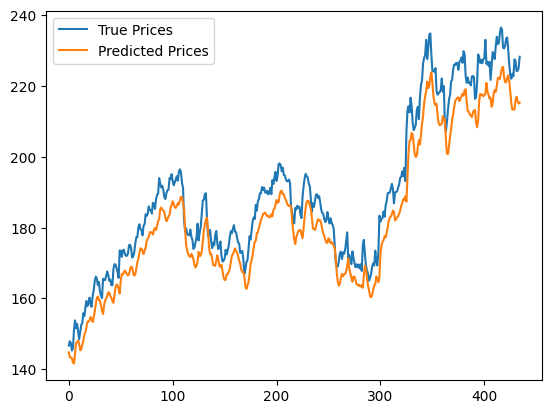

In [32]:
# Plotting the true vs predicted stock prices for comparison
import matplotlib.pyplot as plt
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='True Prices')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.show()

# **Model Optimization**




Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6292e-04 - val_loss: 0.0017
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.5361e-04 - val_loss: 0.0010
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9615e-04 - val_loss: 2.4819e-04
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3833e-04 - val_loss: 2.5694e-04
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3956e-04 - val_loss: 0.0011
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5145e-04 - val_loss: 4.0658e-04
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6166e-04 - val_loss: 5.8128e-04
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4609e-04 - val_loss: 2.4717e-04
Epoch 9/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1498e-04 - val_loss: 3.4594e-04
Epoch 10/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4597e-04 - val_loss: 6.7786e-04
Epoch 11/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.2642e

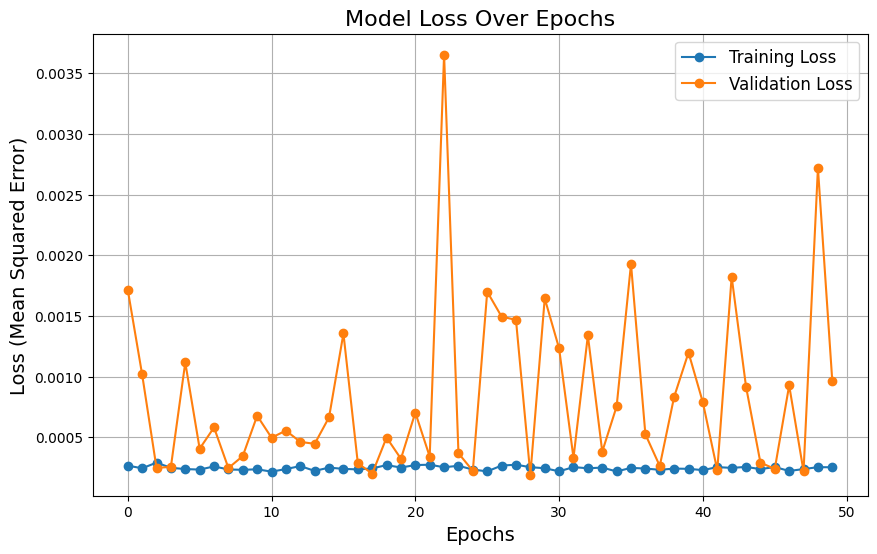

In [39]:
history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

# Extracting loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (Mean Squared Error)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [18]:
# Helper function to build the model
def build_model(lstm_units, lstm_units2, lstm_units3, learning_rate):
    model = Sequential([
              LSTM(lstm_units, return_sequences=True, input_shape=(X_train.shape[1], 1)),
              Dropout(0.2),
              LSTM(lstm_units2, return_sequences=False),
              Dropout(0.2),
              Dense(lstm_units3),
              Dense(1) # Output layer with one neuron (predicting the closing price)
          ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

Grid Search Optimizization

In [20]:
# Parameter ranges for grid search
param_grid = {
    'lstm_units': [25, 50, 100, 150],
    'lstm_units2': [25, 50, 100, 150],
    'lstm_units3': [25, 50, 100, 150],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005]
}

# Grid search for optimization
best_model = None
best_params = None
lowest_val_loss = float('inf')

for lstm_units in param_grid['lstm_units']:
    for lstm_units2 in param_grid['lstm_units2']:
        for lstm_units3 in param_grid['lstm_units3']:
            for batch_size in param_grid['batch_size']:
                for learning_rate in param_grid['learning_rate']:
                    print(f"Testing params: LSTM Units={lstm_units}, Batch Size={batch_size}, Learning Rate={learning_rate}")

                    # Build and train model
                    model = build_model(lstm_units, lstm_units2, lstm_units3, learning_rate,)
                    history = model.fit(
                        X_train, y_train,
                        epochs=30,  # Keep epochs small for testing
                        batch_size=batch_size,
                        validation_split=0.2,
                        verbose=0
                    )

                    # Check validation loss
                    val_loss = min(history.history['val_loss'])
                    if val_loss < lowest_val_loss:
                        lowest_val_loss = val_loss
                        best_model = model
                        best_params = {'lstm_units': lstm_units, 'lstm_units2': lstm_units2, 'lstm_units3': lstm_units3, 'batch_size': batch_size, 'learning_rate': learning_rate}

# Output best parameters and validation loss
print(f"Best Parameters: {best_params}")
print(f"Lowest Validation Loss: {lowest_val_loss}")

Testing params: LSTM Units=25, Batch Size=16, Learning Rate=0.001
Testing params: LSTM Units=25, Batch Size=16, Learning Rate=0.002
Testing params: LSTM Units=25, Batch Size=16, Learning Rate=0.003
Testing params: LSTM Units=25, Batch Size=16, Learning Rate=0.004
Testing params: LSTM Units=25, Batch Size=16, Learning Rate=0.005
Testing params: LSTM Units=25, Batch Size=32, Learning Rate=0.001
Testing params: LSTM Units=25, Batch Size=32, Learning Rate=0.002
Testing params: LSTM Units=25, Batch Size=32, Learning Rate=0.003
Testing params: LSTM Units=25, Batch Size=32, Learning Rate=0.004
Testing params: LSTM Units=25, Batch Size=32, Learning Rate=0.005
Testing params: LSTM Units=25, Batch Size=64, Learning Rate=0.001
Testing params: LSTM Units=25, Batch Size=64, Learning Rate=0.002
Testing params: LSTM Units=25, Batch Size=64, Learning Rate=0.003
Testing params: LSTM Units=25, Batch Size=64, Learning Rate=0.004
Testing params: LSTM Units=25, Batch Size=64, Learning Rate=0.005
Testing pa

KeyboardInterrupt: 

Random Search

In [22]:
import random

# Random Search for Optimization
param_grid = {
    'lstm_units': [25, 50, 100, 150],
    'lstm_units2': [25, 50, 100, 150],
    'lstm_units3': [25, 50, 100, 150],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005]
}

# Number of parameter combinations to try
n_random_trials = 30

# Helper function to build the model
def build_model(lstm_units, lstm_units2, lstm_units3, learning_rate):
    model = Sequential([
        LSTM(units=lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(units=lstm_units2, return_sequences=True),
        Dropout(0.2),
        LSTM(units=lstm_units3, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Random search logic
best_model = None
best_params = None
lowest_val_loss = float('inf')

for _ in range(n_random_trials):
    # Randomly sample parameters
    lstm_units = random.choice(param_grid['lstm_units'])
    lstm_units2 = random.choice(param_grid['lstm_units2'])
    lstm_units3 = random.choice(param_grid['lstm_units3'])
    batch_size = random.choice(param_grid['batch_size'])
    learning_rate = random.choice(param_grid['learning_rate'])

    print(f"Testing params: LSTM Units1={lstm_units}, LSTM Units2={lstm_units2}, "
          f"LSTM Units3={lstm_units3}, Batch Size={batch_size}, Learning Rate={learning_rate}")

    # Build and train model
    model = build_model(lstm_units, lstm_units2, lstm_units3, learning_rate)
    history = model.fit(
        X_train, y_train,
        epochs=10,  # Reduce for faster testing
        batch_size=batch_size,
        validation_split=0.2,
        verbose=0
    )

    # Check validation loss
    val_loss = min(history.history['val_loss'])
    if val_loss < lowest_val_loss:
        lowest_val_loss = val_loss
        best_model = model
        best_params = {
            'lstm_units': lstm_units,
            'lstm_units2': lstm_units2,
            'lstm_units3': lstm_units3,
            'batch_size': batch_size,
            'learning_rate': learning_rate
        }

# Output best parameters and validation loss
print(f"Best Parameters: {best_params}")
print(f"Lowest Validation Loss: {lowest_val_loss}")

Testing params: LSTM Units1=150, LSTM Units2=25, LSTM Units3=150, Batch Size=32, Learning Rate=0.002
Testing params: LSTM Units1=100, LSTM Units2=150, LSTM Units3=150, Batch Size=32, Learning Rate=0.002
Testing params: LSTM Units1=50, LSTM Units2=150, LSTM Units3=100, Batch Size=16, Learning Rate=0.001
Testing params: LSTM Units1=50, LSTM Units2=100, LSTM Units3=25, Batch Size=32, Learning Rate=0.003
Testing params: LSTM Units1=100, LSTM Units2=150, LSTM Units3=100, Batch Size=16, Learning Rate=0.001
Testing params: LSTM Units1=50, LSTM Units2=150, LSTM Units3=25, Batch Size=16, Learning Rate=0.001
Testing params: LSTM Units1=25, LSTM Units2=100, LSTM Units3=100, Batch Size=16, Learning Rate=0.002
Testing params: LSTM Units1=100, LSTM Units2=50, LSTM Units3=50, Batch Size=32, Learning Rate=0.004
Testing params: LSTM Units1=150, LSTM Units2=150, LSTM Units3=25, Batch Size=64, Learning Rate=0.005
Testing params: LSTM Units1=50, LSTM Units2=50, LSTM Units3=25, Batch Size=32, Learning Rate

In [23]:
# Evaluate the best model on the test set
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.8714e-04
Test Loss: 0.0018774665659293532
